In [24]:
import pandas as pd
import numpy as np
import seaborn as sns
from rdkit import Chem
from rdkit.Chem import AllChem
from mordred import Calculator, descriptors

In [25]:
def count_cf_bonds(mol):
    abstract_cf = Chem.MolFromSmarts('C~F')
    cf_bonds = mol.GetSubstructMatches(abstract_cf)
    return len(cf_bonds)

def is_in_dataset(csmiles, dataframe=bcfgen):
    if csmiles is None:
        return False
    else:
        return csmiles in dataframe['cSMILES'].values
    # try except
#     csmiles = Chem.MolToSmiles(Chem.MolFromSmiles(smiles))
#     if csmiles is None:
#         print('Failed to construct mol from SMILES:', smiles)
#         return False
#     else:
#         return csmiles in dataframe['cSMILES'].values
    
def expand_dataset(expanded, dataframe):
    expanded['is_in_dataset'] = expanded['cSMILES'].map(is_in_dataset)
    print('Redundant Compounds:', (expanded.is_in_dataset.values == True).sum())
    print('Novel Compounds:', (expanded.is_in_dataset.values == False).sum())
    
    return expanded[expanded['is_in_dataset'] == False].reset_index(drop=True)
    
def canonicalize(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    else:
        return Chem.MolToSmiles(mol)

In [26]:
# this data processing script allows incorporation of new acquired data through bcfexpanded
# index_col to avoid importing index as independent column
bcfgen = pd.read_csv('data/dataprocessing/bcfgeneralcommon.csv', index_col=0)
bcfpfas = pd.read_csv('data/dataprocessing/bcfpfas.csv', index_col=0)
bcfexpanded = pd.read_excel('Expanded_BCF.xlsx')
unlabeledpfas = pd.read_csv('data/dataprocessing/unlabeled_pfas.csv', index_col=0)

In [27]:
# Canonicalize SMILES and check for duplicates
bcfgen['cSMILES'] = bcfgen.SMILES.apply(canonicalize)
bcfpfas['cSMILES'] = bcfpfas.SMILES.apply(canonicalize)
bcfexpanded['cSMILES'] = bcfexpanded.SMILES.apply(canonicalize)

# Delete duplicate canonical SMILES
bcfgen.drop_duplicates(subset=['cSMILES'], inplace=True, ignore_index=True)
bcfpfas.drop_duplicates(subset=['cSMILES'], inplace=True, ignore_index=True)
bcfexpanded.drop_duplicates(subset=['cSMILES'], inplace=True, ignore_index=True)

In [29]:
# expand bcfgen with additional datapoints collected from pubchem
novel = expand_dataset(bcfexpanded, bcfgen)

# convert to logBCF and only keep CAS, cSMILES and logBCF
# append to the original nonpfas dataset
# novel['cSMILES'] = novel.SMILES.apply(canonicalize)
novel['logBCF'] = np.log10(novel['BCF (L/kg)'])
bcfnew = novel[['CAS', 'cSMILES', 'logBCF']]

# rid any duplicate cSMILES
# bcfnew.drop_duplicates(subset=['cSMILES'], inplace=True, ignore_index=True)

# add to bcfgen
bcfgenplus = pd.concat([bcfgen, bcfnew])

Redundant Compounds: 307
Novel Compounds: 100


In [30]:
# remove pfas intersection in bcfgen dataset (10 datapoints)
doubles = pd.merge(bcfgenplus, bcfpfas, how='inner', on=['cSMILES'])
bcfgenplus = bcfgenplus[~bcfgenplus['cSMILES'].isin(doubles['cSMILES'])].reset_index(drop=True)

# label as pfas or non-pfas
bcfgenplus['Category'] = 0 # non-pfas label
bcfpfas['Category'] = 2 # pfas

In [31]:
# combine pfas and general dataset
bcfcombined = pd.concat([bcfgenplus, bcfpfas]).reset_index(drop=True)
bcfcombined['rd_mol'] = bcfcombined.cSMILES.apply(Chem.MolFromSmiles)
# bcfcombined[bcfcombined['rd_mol'].isnull()]
bcfcombined

,CAS,logBCF,Dataset,SMILES,cSMILES,Category,Chemical,rd_mol
0,2691-41-0,-0.300000,uci,O=[N+]([O-])N1CN([N+](=O)[O-])CN([N+](=O)[O-])...,O=[N+]([O-])N1CN([N+](=O)[O-])CN([N+](=O)[O-])...,0,NaN,<rdkit.Chem.rdchem.Mol object at 0x00000281BEA...
1,541-73-1,2.440000,uci,Clc1cc(ccc1)Cl,Clc1cccc(Cl)c1,0,NaN,<rdkit.Chem.rdchem.Mol object at 0x00000281BEA...
2,55219-65-3,1.320000,uci,OC(C(Oc1ccc(cc1)Cl)n2ncnc2)C(C)(C)C,CC(C)(C)C(O)C(Oc1ccc(Cl)cc1)n1cncn1,0,NaN,<rdkit.Chem.rdchem.Mol object at 0x00000281BEA...
3,55179-31-2/70585-36-3,2.310000,uci,OC(C(Oc1ccc(cc1)c2ccccc2)n3ncnc3)C(C)(C)C,CC(C)(C)C(O)C(Oc1ccc(-c2ccccc2)cc1)n1cncn1,0,NaN,<rdkit.Chem.rdchem.Mol object at 0x00000281BEA...
4,5510-99-6,2.470000,uci,Oc1c(cccc1C(CC)C)C(CC)C,CCC(C)c1cccc(C(C)CC)c1O,0,NaN,<rdkit.Chem.rdchem.Mol object at 0x00000281BEA...
...,...,...,...,...,...,...,...,...
1210,335-76-2,3.889259,itrc,OC(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(...,O=C(O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(...,2,PFDA,<rdkit.Chem.rdchem.Mol object at 0x00000281BE6...
1211,375-22-4,1.184123,itrc,OC(=O)C(F)(F)C(F)(F)C(F)(F)F,O=C(O)C(F)(F)C(F)(F)C(F)(F)F,2,PFBA,<rdkit.Chem.rdchem.Mol object at 0x00000281BE6...
1212,72629-94-8,4.446706,itrc,OC(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(...,O=C(O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(...,2,PFTrDA,<rdkit.Chem.rdchem.Mol object at 0x00000281BE6...
1213,307-55-1,4.000000,itrc,OC(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(...,O=C(O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(...,2,PFDoDA,<rdkit.Chem.rdchem.Mol object at 0x00000281BE6...


In [32]:
unlabeledpfas['rd_mol'] = unlabeledpfas.cSMILES.apply(Chem.MolFromSmiles)
# unlabeledpfas['rd_mol'].isnull().sum()

# Mordred Fingerprints

In [33]:
mordred = Calculator(descriptors, ignore_3D=False)

mordred_descriptors = mordred.pandas(bcfcombined['rd_mol'])

  5%|███▊                                                                            | 57/1215 [00:05<01:32, 12.57it/s]

C:\Users\david\anaconda3\envs\env4pfas\lib\site-packages\numpy\core\fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


 60%|███████████████████████████████████████████████▎                               | 728/1215 [00:28<00:14, 33.16it/s]

C:\Users\david\anaconda3\envs\env4pfas\lib\site-packages\numpy\core\fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


 67%|████████████████████████████████████████████████████▉                          | 814/1215 [00:30<00:09, 41.95it/s]

C:\Users\david\anaconda3\envs\env4pfas\lib\site-packages\numpy\core\fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


 74%|██████████████████████████████████████████████████████████▍                    | 899/1215 [00:33<00:11, 27.13it/s]

C:\Users\david\anaconda3\envs\env4pfas\lib\site-packages\numpy\core\fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


 80%|███████████████████████████████████████████████████████████████▎               | 974/1215 [00:38<00:19, 12.20it/s]

C:\Users\david\anaconda3\envs\env4pfas\lib\site-packages\numpy\core\fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


 86%|███████████████████████████████████████████████████████████████████▏          | 1047/1215 [00:41<00:06, 24.74it/s]

C:\Users\david\anaconda3\envs\env4pfas\lib\site-packages\numpy\core\fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


 92%|███████████████████████████████████████████████████████████████████████▍      | 1112/1215 [00:43<00:03, 30.67it/s]

C:\Users\david\anaconda3\envs\env4pfas\lib\site-packages\numpy\core\fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


  0%|▏                                                                                | 6/3866 [00:04<33:03,  1.95it/s]

C:\Users\david\anaconda3\envs\env4pfas\lib\site-packages\numpy\core\fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


  2%|█▉                                                                              | 93/3866 [00:12<10:35,  5.94it/s]

C:\Users\david\anaconda3\envs\env4pfas\lib\site-packages\numpy\core\fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


  4%|██▉                                                                            | 143/3866 [00:16<11:10,  5.55it/s]

C:\Users\david\anaconda3\envs\env4pfas\lib\site-packages\numpy\core\fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\david\anaconda3\envs\env4pfas\lib\site-packages\numpy\core\fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\david\anaconda3\envs\env4pfas\lib\site-packages\numpy\core\fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\david\anaconda3\envs\env4pfas\lib\site-packages\numpy\core\fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


  9%|███████                                                                        | 344/3866 [00:33<03:43, 15.73it/s]

C:\Users\david\anaconda3\envs\env4pfas\lib\site-packages\numpy\core\fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


 13%|█████████▉                                                                     | 489/3866 [00:46<07:09,  7.86it/s]

C:\Users\david\anaconda3\envs\env4pfas\lib\site-packages\numpy\core\fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


100%|██████████████████████████████████████████████████████████████████████████████| 3866/3866 [05:29<00:00, 11.73it/s]


In [37]:
# There exists strange missing values!
# convert all to float to get proper NaNs
mordred_descriptors = mordred_descriptors.astype(float)

# bcf mordred before additional cleaning steps
bcf_mordred = pd.concat([bcfcombined, mordred_descriptors], axis = 1)

Text(0.5, 1.0, 'Descriptor NaN Distribution')

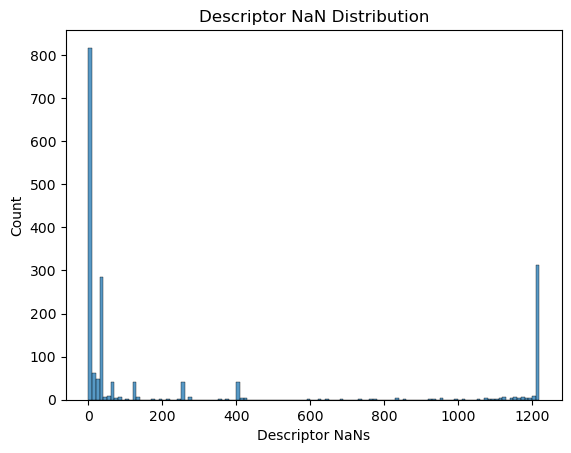

In [35]:
# goal here is to save as many descriptors as possible before doing dropna
# filter for columns that only have few nan values caused by select chemicals, then remove those chemicals
e = mordred_descriptors.isnull().sum().sort_values(ascending=False)
e = e.to_frame(name='NaN Count')

# histogram shows that there are ~300+ descriptors that can be retrieved by removing small number of compounds
ax = sns.histplot(data=e, x="NaN Count", binwidth=10)
ax.set(xlabel = "Descriptor NaNs")
ax.set_title("Descriptor NaN Distribution")

In [38]:
# function that resolves low level error descriptors
def resolve(data, error_table, max_error):
    # searches descriptors with less than max_error NaNs
    # returns list of compounds by index that are responsible for breaking low level error descriptors
    compounds = set()
    for i in range(1, max_error):
        # get all descriptor names
        descriptors = list(error_table[error_table['NaN Count'] == i].index)

        # aggregate all compound indices in those descriptors that are problematic
        for descriptor in descriptors:
            compounds = compounds.union(set(data[data[descriptor].isnull()].index))
        
    return list(compounds)

l = resolve(mordred_descriptors, e, 30)
print('There are', len(l), 'problematic compounds for Mordred descriptors:')
print(l)

# Debugging:
# e[e['NaN Count'] == 4]
# Look for common denominator of these low level errors:
# bcf_mordred[bcf_mordred['Xp-0d'].isnull()]

bcf_mordred_partial = bcf_mordred.drop(l, errors='ignore')
bcf_mordred_partial.reset_index(drop=True, inplace=True)

There are 49 problematic compounds for Mordred descriptors:
[1036, 1038, 1039, 1040, 528, 1042, 1043, 1048, 24, 26, 1052, 1053, 1054, 1055, 1056, 1058, 1059, 1060, 1061, 1062, 1063, 809, 1073, 1080, 321, 578, 582, 583, 584, 1097, 585, 1104, 1112, 1113, 1114, 605, 1136, 1138, 1139, 1141, 1166, 1181, 1182, 934, 936, 973, 471, 234, 1022]


In [65]:
unfiltered = mordred_descriptors.dropna(axis=1)
print('Originally only', len(unfiltered.columns), 'usable descriptors.')

# Drop all remaining bad descriptors
# How many descriptors do we have left?
bcf_mordred_partial.drop(columns=['CAS', 'SMILES', 'Dataset', 'rd_mol', 'Chemical'], axis=1, inplace=True, errors='ignore')
bcf_mordred_partial.dropna(how='any', axis='columns', inplace=True)
print("After resolution, there are now", len(bcf_mordred_partial.columns) - 6, " Mordred descriptors")

# Alternatively, losing descriptors and keeping compounds
bcf_mordred.drop(columns=['CAS', 'SMILES', 'Dataset', 'rd_mol', 'Chemical'], axis=1, inplace=True, errors='ignore')
bcf_mordred.dropna(how='any', axis='columns', inplace=True) # BEWARE NOT TO DROP NA CAS

Originally only 765 usable descriptors.
After resolution, there are now 928  Mordred descriptors


In [66]:
# bcf mordred cleaned dataset ready for prediction
bcf_mordred_partial.to_csv('data/featureset/labeled/bcf_mordred_partial.csv')
bcf_mordred.to_csv('data/featureset/labeled/bcf_mordred_full.csv')

# ECFP4 Fingerprints

In [43]:
# bcfgen ecfp4 1024, 2048
# ecfp4_1024, 2048
def create_morgan_space(r = 2, nbits = 128):
    def model(mol):
        return AllChem.GetMorganFingerprintAsBitVect(mol, radius = r, nBits = nbits)
    return model

ecfp4_1024 = pd.DataFrame(np.array(bcfcombined.rd_mol.apply(create_morgan_space(r = 2, nbits = 1024)).tolist()).astype(np.float32))
ecfp4_2048 = pd.DataFrame(np.array(bcfcombined.rd_mol.apply(create_morgan_space(r = 2, nbits = 2048)).tolist()).astype(np.float32))
ecfp4_4096 = pd.DataFrame(np.array(bcfcombined.rd_mol.apply(create_morgan_space(r = 2, nbits = 4096)).tolist()).astype(np.float32))

# unlabeled
unlabeled_ecfp4_1024 = pd.DataFrame(np.array(unlabeledpfas.rd_mol.apply(create_morgan_space(r = 2, nbits = 1024)).tolist()).astype(np.float32))
unlabeled_ecfp4_2048 = pd.DataFrame(np.array(unlabeledpfas.rd_mol.apply(create_morgan_space(r = 2, nbits = 2048)).tolist()).astype(np.float32))
unlabeled_ecfp4_4096 = pd.DataFrame(np.array(unlabeledpfas.rd_mol.apply(create_morgan_space(r = 2, nbits = 4096)).tolist()).astype(np.float32))

In [68]:
bcf_ecfp4 = pd.concat([bcfcombined, ecfp4_1024], axis = 1)
bcf_ecfp4.reset_index(drop=True, inplace=True)
bcf_ecfp4.drop(columns=['CAS', 'SMILES', 'Dataset', 'rd_mol', 'Chemical'], axis=1, inplace=True, errors='ignore')
bcf_ecfp4.to_csv('data/featureset/labeled/bcf_ecfp4_1024.csv')

In [69]:
bcf_ecfp4 = pd.concat([bcfcombined, ecfp4_2048], axis = 1)
bcf_ecfp4.reset_index(drop=True, inplace=True)
bcf_ecfp4.drop(columns=['CAS', 'SMILES', 'Dataset', 'rd_mol', 'Chemical'], axis=1, inplace=True, errors='ignore')
bcf_ecfp4.to_csv('data/featureset/labeled/bcf_ecfp4_2048.csv')

In [70]:
bcf_ecfp4 = pd.concat([bcfcombined, ecfp4_4096], axis = 1)
bcf_ecfp4.reset_index(drop=True, inplace=True)
bcf_ecfp4.drop(columns=['CAS', 'SMILES', 'Dataset', 'rd_mol', 'Chemical'], axis=1, inplace=True, errors='ignore')
bcf_ecfp4.to_csv('data/featureset/labeled/bcf_ecfp4_4096.csv')

In [45]:
# unlabeled
unlabeled_ecfp4_1024.to_csv('data/featureset/unlabeled/bcf_ecfp4_1024.csv')
unlabeled_ecfp4_2048.to_csv('data/featureset/unlabeled/bcf_ecfp4_2048.csv')
unlabeled_ecfp4_4096.to_csv('data/featureset/unlabeled/bcf_ecfp4_4096.csv')

# Graph Representation? (TBD)